# 1. Pre-processing

#### 1.1. Text Pre-processing

The dataset is already lowercased and lacks punctuation. We will tokenize the text and remove stopwords, as well as apply lemmatization to the tokens.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction import text

#words to keep: no couldnt cry not cant cannot nor except nobody off but serious enough nothing alone down only without


data = pd.read_json('./data/data.jsonl', lines=True)
original_data = data.copy() # never lemmatized

#remove stop words
my_stop_words = text.ENGLISH_STOP_WORDS
#print(my_stop_words)
words_to_keep = frozenset(['no', 'couldnt', 'cry', 'not', 'cant', 'cannot', 'nor', 'except', 'nobody', 'off', 'but', 'serious', 'enough', 'nothing', 'alone', 'down', 'only', 'without','hereby'])
my_stop_words = my_stop_words - words_to_keep

def pre_process_data(dataset):
    #tokenize
    dataset['text'] = dataset['text'].apply(nltk.word_tokenize)
    
    dataset['text'] = dataset['text'].apply(lambda x: [word for word in x if word not in my_stop_words])

    #lemmatize
    lemmatizer = WordNetLemmatizer()
    dataset['text'] = dataset['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    return dataset

data = pre_process_data(data)
data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcarv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcarv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcarv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,"[feel, awful, s, job, position, succeed, just,...",0
1,"[im, alone, feel, awful]",0
2,"[ive, probably, mentioned, but, really, feel, ...",1
3,"[feeling, little, low, day]",0
4,"[beleive, sensitive, people, feeling, tend, co...",2


In [29]:
test_data = pd.read_json('./data/test_final.jsonl', lines=True)
train_data = pd.read_json('./data/train_final.jsonl', lines=True)
validation_data = pd.read_json('./data/validation_final.jsonl', lines=True)



# remove duplicates
test_data = test_data.drop_duplicates(subset=['text'])
train_data = train_data.drop_duplicates(subset=['text'])
validation_data = validation_data.drop_duplicates(subset=['text'])

original_test_data = test_data.copy()
original_test_data['text'] = original_test_data['text'].apply(nltk.word_tokenize)
original_train_data = train_data.copy()
original_train_data['text'] = original_train_data['text'].apply(nltk.word_tokenize)
original_validation_data = validation_data.copy()
original_validation_data['text'] = original_validation_data['text'].apply(nltk.word_tokenize)

test_data = pre_process_data(test_data)
train_data = pre_process_data(train_data)
validation_data = pre_process_data(validation_data)
print(test_data['text'][13])

print(test_data["text"])

['woke', 'feeling', 'particularly', 'vile', 'tried', 'ignore', 'but', 'got', 'worse', 'worse', 'worse']
0       [feel, awful, s, job, position, succeed, just,...
1                                [im, alone, feel, awful]
2       [ive, probably, mentioned, but, really, feel, ...
3                             [feeling, little, low, day]
4       [beleive, sensitive, people, feeling, tend, co...
                              ...                        
5395              [feel, grumpy, haven, t, yoga, ed, day]
5396    [read, blog, suburb, direction, mentioned, cas...
5397    [not, feel, thing, realize, violent, physical,...
5398    [feel, petty, silly, giving, shit, but, little...
5399    [remember, feeling, bitter, couldnt, pop, ball...
Name: text, Length: 5396, dtype: object


# 2. Vectorization
In this section we will experiment different featurization techniques, using sparse and dense vector techniqques

### TF-IDF

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfVectorizer(train_data, validation_data, test_data):
    vectorizer = TfidfVectorizer(stop_words=list(my_stop_words), ngram_range=(1,2), max_features=40000)
    # print(X.shape)

    x_train = vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))
    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']
    
    # print(vectorizer.get_feature_names_out())

    return x_train, x_val, x_test, y_train, y_val, y_test



### BOW model
Count vectorizer which is an implementation of the BOW model.

The disadvantage of the BOW model is it does not consider the sequence of words, and as language does involve sequence and context, sometimes the BOW model might not be a good fit for the best-case scenario.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def countVectorizer(train_data, validation_data, test_data):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(stop_words=my_stop_words, ngram_range=(1,2), max_features=40000)

    x_train= vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



### Doc 2 Vec

### Hypertunning doc2vec

In [5]:
# import optuna
# from gensim.models import Doc2Vec
# from gensim.models.doc2vec import TaggedDocument
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# import numpy as np

# y_train = train_data['label']
# y_val = validation_data['label']

# def objective(trial):
#     vector_size = trial.suggest_int("vector_size", 50, 300)
#     window = trial.suggest_int("window", 3, 15)
#     min_count = trial.suggest_int("min_count", 1, 10)
#     epochs = trial.suggest_int("epochs", 10, 50)
    
#     # Train Doc2Vec model
#     tagged_data = [TaggedDocument(words=doc, tags=[str(label)]) for doc, label in zip(train_data['text'], train_data['label'])]
#     doc2vec_model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, epochs=epochs)
#     doc2vec_model.build_vocab(tagged_data)
#     doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    
#     # Prepare document vectors for training and test sets
#     X_train_vecs  = [doc2vec_model.infer_vector(doc) for doc in train_data['text']]
#     X_val_vecs = [doc2vec_model.infer_vector(doc) for doc in validation_data['text']]
    
#     # Train Logistic Regression classifier
#     classifier = LogisticRegression(max_iter=1000)
#     classifier.fit(X_train_vecs, y_train)
    
#     # Evaluate on test set
#     y_pred = classifier.predict(X_val_vecs)
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# print("Best hyperparameters:", best_params)


#### Training doc2vec 

In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils

def train_doc2vec(train_data):
    max_epochs = 16
    vec_size = 88
    alpha = 0.025
    window = 4
    min_count = 7

    tagged_data = [TaggedDocument(words=doc, tags=[str(label)]) for doc, label in zip(train_data['text'], train_data['label'])]

    # antes tinha workers definidos
    model = Doc2Vec(vector_size=vec_size, window=window, min_count=min_count, epochs=max_epochs)
    
    model.build_vocab(tagged_data)


    model.train(tagged_data, total_examples=model.corpus_count, epochs=50)

    model.save("d2v_best_stopwords.model")
    print("Model Saved")

    return model

#train_doc2vec(train_data)

#### Using the trained model

In [7]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
from gensim.models.doc2vec import Doc2Vec
from sklearn.decomposition import PCA

def doc2vec(train_data, validation_data, test_data):

    # training the doc2vec model
    #model = train_doc2vec(train_data)
    model = Doc2Vec.load("d2v_best_stopwords.model")
    
    x_train = [model.infer_vector(doc) for doc in train_data['text']]
    x_val = [model.infer_vector(doc) for doc in validation_data['text']]
    x_test = [model.infer_vector(doc) for doc in test_data['text']]

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test

### Word embeddings using pre-trained models from twitter

In [8]:
from gensim.models import Word2Vec
import numpy as np
import gensim.downloader as api


def text_to_vector(embeddings, text, sequence_len):
    
    # split text into tokens
    tokens = text.split()
    
    # convert tokens to embedding vectors, up to sequence_len tokens
    vec = []
    n = 0
    i = 0
    while i < len(tokens) and n < sequence_len:   # while there are tokens and did not reach desired sequence length
        try:
            vec.extend(embeddings.get_vector(tokens[i]))
            n += 1
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
        finally:
            i += 1
    
    # add blanks up to sequence_len, if needed
    for j in range(sequence_len - n):
        vec.extend(np.zeros(embeddings.vector_size,))
    
    return vec

def text_to_mean_vector(embeddings, text):
     # split text into tokens
    tokens = text.split()

    # convert tokens to embedding vectors, up to sequence_len tokens
    total_vector = []
    i = 0
    while i < len(tokens):   # while there are tokens and did not reach desired sequence length
        try:
            total_vector.append(embeddings.get_vector(tokens[i]))
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
        finally:
            i += 1

    return np.mean(total_vector, axis=0)

def documents_to_vectors(embeddings, documents, sequence_len):
    vectors = []
    for doc in documents:
        vectors.append(text_to_vector(embeddings, doc, sequence_len))
    return np.array(vectors)


def documents_to_mean_vectors(embeddings, documents):
    vectors = []
    for doc in documents:
        vectors.append(text_to_mean_vector(embeddings, doc))
    return np.array(vectors)

def wordEmbeddingsVectorizer(train_data, validation_data, test_data):
    
    # use twitter word embeddings
    model_glove_twitter = api.load("glove-twitter-25")
    
    # Initialize Word2Vec
    
    train = train_data['text'].apply(lambda x: ' '.join(x))
    val = validation_data['text'].apply(lambda x: ' '.join(x))
    test = test_data['text'].apply(lambda x: ' '.join(x))
    
    x_train = documents_to_vectors(model_glove_twitter, train, 40)
    x_val = documents_to_vectors(model_glove_twitter, val, 40)
    x_test = documents_to_vectors(model_glove_twitter, test, 40)
    
    print(x_train.shape, x_val.shape, x_test.shape)
    print(x_train[0])
    
    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test


def wordEmbeddingsMeanVectorizer(train_data, validation_data, test_data):

    # use twitter word embeddings
    model_glove_twitter = api.load("glove-twitter-25")

    # Initialize Word2Vec

    train = train_data['text'].apply(lambda x: ' '.join(x))
    val = validation_data['text'].apply(lambda x: ' '.join(x))
    test = test_data['text'].apply(lambda x: ' '.join(x))

    x_train = documents_to_mean_vectors(model_glove_twitter, train)
    x_val = documents_to_mean_vectors(model_glove_twitter, val)
    x_test = documents_to_mean_vectors(model_glove_twitter, test)

    # x_train = np.mean(x_train, axis=1)
    # x_val = np.mean(x_val, axis=1)
    # x_test = np.mean(x_test, axis=1)
    #
    print(x_train.shape, x_val.shape, x_test.shape)
    print(x_train[0])

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test


### Word2Vec - Word embeddings using gensim model 

### Hypertunne the word 2 vec model

In [9]:
# from gensim.models import Word2Vec
# import numpy as np
# import optuna
# from sklearn.metrics import f1_score
# from sklearn.svm import SVC

# # Calculate mean for each dimension
# def calculate_mean_vectors(model, data):
#     vectors = []
#     for doc in data['text']:
#         document = []
#         for word in doc:
#             if word in model.wv:
#                 document.append(model.wv[word])
#         if document:
#             vectors.append(np.mean(document, axis=0))
#         else:
#             vectors.append(np.zeros(model.vector_size))
#     return np.array(vectors)

# def word_embeddings_vectorizer(train_data, validation_data, test_data, vector_size, window, min_count, sg):
#     data_model = Word2Vec(train_data["text"], vector_size=vector_size, window=window, min_count=min_count, sg=sg)
    
#     x_train = calculate_mean_vectors(data_model, train_data)
#     x_val = calculate_mean_vectors(data_model, validation_data)
#     x_test = calculate_mean_vectors(data_model, test_data)

#     y_train = train_data['label']
#     y_val = validation_data['label']
#     y_test = test_data['label']

#     return x_train, x_val, x_test, y_train, y_val, y_test


# def objective(trial):
#     # Define the search space for hyperparameters
#     vector_size = trial.suggest_int('vector_size', 50, 300)
#     window = trial.suggest_int('window', 2, 10)
#     min_count = trial.suggest_int('min_count', 1, 5)
#     sg = trial.suggest_categorical('sg', [0, 1])
    
#     x_train, x_val, x_test, y_train, y_val, y_test = word_embeddings_vectorizer(train_data, validation_data, test_data, vector_size, window, min_count, sg)
    
#     # Train an SVC classifier
#     svc = SVC()
#     svc.fit(x_train, y_train)
    
#     # Predict on the validation set
#     y_pred = svc.predict(x_val)
    
#     # Calculate F1 score
#     f1 = f1_score(y_val, y_pred, average='weighted')  # Use weighted average for multiclass classification
    
#     return f1

# if __name__ == "__main__":
#     study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
#     study.optimize(objective, n_trials=100)  # You can adjust the number of trials as needed

#     print('Number of finished trials:', len(study.trials))
#     print('Best trial:', study.best_trial.params)
#     print('Best f1:', study.best_value)


In [10]:
from gensim.models import Word2Vec
import numpy as np

## calcular media a cada dimensão
def my_word2vec_model(model, data):
    vectors = []
    for doc in data['text']:
        document = []
        for word in doc:
            if word in model.wv:
                document.append(model.wv[word])
        if document:  # Check if the document is not empty
            vectors.append(np.mean(document, axis=0))  # Take the mean of word vectors for each document
        else:
            # If the document is empty, append a zero vector
            vectors.append(np.zeros(model.vector_size))
    
    return np.array(vectors)


def wordEmbeddingsVectorizer_Trained(train_data,  validation_data, test_data):

    # Hypertunning 1: 'vector_size': 120, 'window': 7, 'min_count': 3, 'sg': 1
    data_model = Word2Vec(train_data["text"], vector_size=88, window=10, min_count=2, workers=10, sg=1)
    
    x_train = my_word2vec_model(data_model, train_data)
    x_val = my_word2vec_model(data_model, validation_data)
    x_test = my_word2vec_model(data_model, test_data)

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



### Lexicons

In [11]:
from nrclex import NRCLex
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

lexicon_emotions = ['fear','anger', 'anticip', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy', 'anticipation']

def get_features(data):
    features = []
    for text in data['text']:
        text = ' '.join(text)
        text = NRCLex(text)
        features.append([text.affect_frequencies.get(emotion, 0) for emotion in lexicon_emotions])
    return features

# text_object = NRCLex(text='I am nervous')
# print(text_object.affect_frequencies)
# print(text_object.affect_dict)
# print(text_object.top_emotions)
# print(text_object.affect_list)
# print(text_object.raw_emotion_scores)
# print(text_object.lexicon)


def lexiconVectorizer(train_data, validation_data, test_data):
    x_train = get_features(train_data)
    x_val = get_features(validation_data)
    x_test = get_features(test_data)

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test

## Choosing the vectorizer

In [93]:
# Choose vectorizer (featurizer)
# x_train, x_val, x_test, y_train, y_val, y_test = tfidfVectorizer(train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = countVectorizer(train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsMeanVectorizer(train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsVectorizer_Trained(train_data, validation_data, test_data)
x_train, x_val, x_test, y_train, y_val, y_test = doc2vec(data, train_data, validation_data, test_data)


### Attempt using lexicons

In [92]:
# # store the features
# import joblib
# folder = 'features/'
# joblib.dump(x_train, folder + 'x_train.pkl')
# joblib.dump(x_val, folder + 'x_val.pkl')
# joblib.dump(x_test, folder + 'x_test.pkl')
# joblib.dump(y_train, folder + 'y_train.pkl')
# joblib.dump(y_val, folder + 'y_val.pkl')
# joblib.dump(y_test, folder + 'y_test.pkl')


['features/y_test.pkl']

In [30]:
# join the features
# import numpy as np

# Using with lexicon 
#x_train_lexicon, x_val_lexicon, x_test_lexicon, y_train_lexicon, y_val_lexicon, y_test_lexicon = lexiconVectorizer(original_train_data, original_validation_data, original_test_data)


In [36]:
# join the features
# x_train_lexicon2 = np.array(x_train_lexicon)
# print(x_train_lexicon2.shape)
# x_train2 = np.concatenate((x_train, x_train_lexicon), axis=1)
# x_val2 = np.hstack((x_val.toarray(), x_val_lexicon))
# x_test2 = np.hstack((x_test.toarray(), x_test_lexicon))


(42607, 11)


ValueError: zero-dimensional arrays cannot be concatenated

In [38]:
# print(x_train.shape)
# print(x_train_lexicon[:3])
# print(x_train[:3])

(42607, 40000)
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0], [0.15384615384615385, 0.07692307692307693, 0.0, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.15384615384615385, 0.15384615384615385, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693], [0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.4, 0.2, 0.2, 0.0, 0]]
  (0, 32595)	0.44382415483477683
  (0, 9534)	0.5180883291594622
  (0, 17720)	0.7248221208380449
  (0, 10609)	0.09611189269695694
  (1, 12131)	0.5456063331751863
  (1, 33361)	0.5444785796625673
  (1, 16005)	0.43594965484883114
  (1, 11801)	0.15183366990167263
  (1, 33353)	0.4390344412561912
  (2, 11161)	0.5270701621378975
  (2, 31956)	0.42658852580279044
  (2, 18561)	0.6010116053088199
  (2, 18174)	0.41386721188137643
  (2, 10609)	0.08785360010257795


#### Hypertunning number of features (using PCA) for each model

In [ ]:
# import optuna
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.svm import SVC
# import lightgbm as lgb

# def objective(trial):
#     # Define parameters to search
#     n_components = trial.suggest_int('n_components', 2, 25)
    
#     # Define the pipeline with PCA and a classifier
#     pipeline = Pipeline([
#         ('pca', PCA(n_components=n_components)),
#         #('clf', SVC())
#         ('clf', lgb.LGBMClassifier())
#         #('clf', LogisticRegression())
#     ])

#     # Fit the pipeline
#     pipeline.fit(x_train, y_train)
    
#     # Evaluate on the validation set
#     y_pred = pipeline.predict(x_val)
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Optimize hyperparameters
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get the best parameters found
# best_params = study.best_params

# # Get the best model
# best_n_components = best_params['n_components']
# best_model = Pipeline([
#     ('pca', PCA(n_components=best_n_components)),
#     ('clf', )  
# ])
# best_model.fit(x_train, y_train)

# # Use the best model for prediction
# y_pred = best_model.predict(x_test)

# # Evaluate the best model
# accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", accuracy)



# 3. Model Training

#### 3.1. Model Selection
Aqui também só estava a querer espetar modelos para começar a ver o que dá que ainda não sei que features vão ser usadas:
tf-idf, word embeddings, ???, features mais feitas à mão?


Isto pelos vistos é uma cena, que não implementei (ainda..)

"The validation set uses a subset of the training data to provide an unbiased evaluation of a model. The validation data set contrasts with training and test sets in that it is an intermediate phase used for choosing the best model and optimizing it. It is in this phase that hyperparameter tuning occurs."

Wikipedia:
The basic process of using a validation data set for model selection (as part of training data set, validation data set, and test data set) is:

Since our goal is to find the network having the best performance on new data, the simplest approach to the comparison of different networks is to evaluate the error function using data which is independent of that used for training. Various networks are trained by minimization of an appropriate error function defined with respect to a training data set. The performance of the networks is then compared by evaluating the error function using an independent validation set, and the network having the smallest error with respect to the validation set is selected. This approach is called the hold out method. Since this procedure can itself lead to some overfitting to the validation set, the performance of the selected network should be confirmed by measuring its performance on a third independent set of data called a test set.

An application of this process is in early stopping, where the candidate models are successive iterations of the same network, and training stops when the error on the validation set grows, choosing the previous model (the one with minimum error).

##### 3.1.1. Logistic Regression

##### Model hypertunning

In [ ]:
# import optuna
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split

# # Define objective function for Optuna
# # Define objective function for Optuna
# def objective(trial):
#     # Define solver
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    
#     if solver == 'lbfgs':
#         penalty = 'l2'  # LBFGS only supports L2 penalty
#     else:
#         penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
#     C = trial.suggest_loguniform('C', 0.01, 10)
    
#     # Instantiate Logistic Regression classifier with hyperparameters
#     logreg_classifier = LogisticRegression(max_iter=1000, solver=solver, penalty=penalty, C=C)
    
#     # Train classifier
#     logreg_classifier.fit(x_train, y_train)
    
#     # Predict on validation set
#     y_pred = logreg_classifier.predict(x_val)
    
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)

##### Model Training

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# pca = PCA(n_components=77)
# x_train = pca.fit_transform(x_train)
# x_val = pca.transform(x_val)
# x_test = pca.transform(x_test)

logreg_classifier = LogisticRegression(solver='liblinear', penalty='l2', C=0.03784347512520397)
logreg_classifier.fit(x_train, y_train)

LogisticRegression(C=0.03784347512520397, solver='liblinear')

In [95]:
y_pred = logreg_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.8306780288995924
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1566
           1       0.92      0.81      0.86      1835
           2       0.61      0.81      0.70       432
           3       0.82      0.82      0.82       756
           4       0.82      0.82      0.82       593
           5       0.50      0.81      0.62       216

    accuracy                           0.83      5398
   macro avg       0.76      0.82      0.78      5398
weighted avg       0.85      0.83      0.84      5398

[[1364   38   33   55   37   39]
 [  55 1486  157   42   30   65]
 [  16   40  352    5    3   16]
 [  43   24   20  623   21   25]
 [  24   12   11   35  485   26]
 [   5   13    7    1   16  174]]


## SVM


##### Model Hypertunning

In [ ]:
# import optuna
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split

# # Define objective function for Optuna
# def objective(trial):
#     # Define kernel
#     kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    
#     # For 'poly', 'rbf', and 'sigmoid' kernels, suggest degree parameter
#     if kernel in ['poly', 'rbf', 'sigmoid']:
#         degree = trial.suggest_int('degree', 2, 5)
#     else:
#         degree = 3  # Default degree value for kernels that don't use it
    
#     # Instantiate SVM classifier with hyperparameters
#     svm_classifier = SVC(kernel=kernel, degree=degree)
    
#     # Train classifier
#     svm_classifier.fit(x_train, y_train)
    
#     # Predict on validation set
#     y_pred = svm_classifier.predict(x_val)
    
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)

# #[I 2024-04-01 12:39:28,014] Trial 36 finished with value: 0.8245 and parameters: {'kernel': 'poly', 'degree': 2}. Best is trial 36 with value: 0.8245.


### Training

In [96]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

svm_classifier = SVC(kernel='poly', degree=2, random_state=42)
svm_classifier.fit(x_train, y_train)

SVC(degree=2, kernel='poly', random_state=42)

In [98]:
y_pred = svm_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8386439422008151
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88      1566
           1       0.92      0.84      0.88      1835
           2       0.64      0.82      0.72       432
           3       0.81      0.82      0.82       756
           4       0.81      0.83      0.82       593
           5       0.55      0.86      0.67       216

    accuracy                           0.84      5398
   macro avg       0.77      0.84      0.80      5398
weighted avg       0.85      0.84      0.84      5398

Confusion Matrix:
 [[1340   40   26   67   55   38]
 [  40 1533  143   39   26   54]
 [  19   41  354    3    2   13]
 [  41   29   21  622   19   24]
 [  19   16   10   32  493   23]
 [   6    8    3    1   13  185]]


## KNN

##### Hypertunning

In [ ]:
# import optuna
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split
# 
# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to optimize
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
#     weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
#     algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
#     
#     # Instantiate KNN classifier with hyperparameters
#     knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
#     
#     # Train classifier
#     knn_classifier.fit(x_train, y_train)
#     
#     # Predict on validation set
#     y_pred = knn_classifier.predict(x_val)
#     
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)
# 
#     return accuracy
# 
# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# 
# # Get best hyperparameters
# best_params = study.best_params
# 
# print(best_params)
# 
# # [I 2024-04-01 13:53:46,403] Trial 26 finished with value: 0.701 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 26 with value: 0.701.

In [99]:
from sklearn.neighbors import KNeighborsClassifier

#knn_classifier = KNeighborsClassifier(n_neighbors=5)
hyperparameters = {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto'}
knn_classifier = KNeighborsClassifier(**hyperparameters)
knn_classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [100]:
y_pred = knn_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7389773990366802
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      1566
           1       0.87      0.73      0.79      1835
           2       0.49      0.75      0.59       432
           3       0.68      0.71      0.70       756
           4       0.73      0.68      0.70       593
           5       0.45      0.75      0.57       216

    accuracy                           0.74      5398
   macro avg       0.67      0.73      0.69      5398
weighted avg       0.77      0.74      0.75      5398

Confusion Matrix:
 [[1233   72   64  104   49   44]
 [  97 1331  197   72   46   92]
 [  24   49  323   18    8   10]
 [  86   40   33  538   38   21]
 [  56   26   31   49  401   30]
 [  12   13    7   10   11  163]]


### Boosting Algorithms

Testing with some boosting algorithms

##### XGBOOST

In [101]:
import xgboost as xgb
# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [102]:
y_pred = xgb_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.797332345313079
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      1566
           1       0.92      0.78      0.84      1835
           2       0.56      0.81      0.66       432
           3       0.76      0.77      0.77       756
           4       0.75      0.79      0.77       593
           5       0.46      0.83      0.59       216

    accuracy                           0.80      5398
   macro avg       0.72      0.80      0.75      5398
weighted avg       0.83      0.80      0.81      5398

Confusion Matrix:
 [[1288   36   43   85   60   54]
 [  50 1435  182   53   38   77]
 [  13   38  349   11    3   18]
 [  47   29   30  585   41   24]
 [  25   18   15   30  468   37]
 [   7    6    7    2   15  179]]


##### Lightgbm

In [103]:
import lightgbm as lgb

lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(x_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22440
[LightGBM] [Info] Number of data points in the train set: 42607, number of used features: 88
[LightGBM] [Info] Start training from score -1.783928
[LightGBM] [Info] Start training from score -1.795592
[LightGBM] [Info] Start training from score -1.775718
[LightGBM] [Info] Start training from score -1.780023
[LightGBM] [Info] Start training from score -1.812270
[LightGBM] [Info] Start training from score -1.803540


LGBMClassifier()

In [104]:
y_pred_lgb = lgb_classifier.predict(x_val)

# Evaluate the performance for LightGBM
accuracy_lgb = accuracy_score(y_val, y_pred_lgb)
report_lgb = classification_report(y_val, y_pred_lgb)
conf_matrix_lgb = confusion_matrix(y_val, y_pred_lgb)

# Print the evaluation metrics for LightGBM
print("\nLightGBM Classifier Evaluation:")
print("Accuracy:", accuracy_lgb)
print("Classification Report:\n", report_lgb)
print("Confusion Matrix:\n", conf_matrix_lgb)


LightGBM Classifier Evaluation:
Accuracy: 0.7954798073360504
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      1566
           1       0.92      0.78      0.84      1835
           2       0.56      0.80      0.66       432
           3       0.78      0.78      0.78       756
           4       0.73      0.77      0.75       593
           5       0.45      0.82      0.58       216

    accuracy                           0.80      5398
   macro avg       0.72      0.80      0.75      5398
weighted avg       0.82      0.80      0.80      5398

Confusion Matrix:
 [[1294   42   39   77   66   48]
 [  53 1433  179   48   37   85]
 [  13   38  346    7   10   18]
 [  46   22   29  586   44   29]
 [  27   17   23   34  457   35]
 [   7   10    5    2   14  178]]


In [105]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(x_train, y_train)


AdaBoostClassifier()

In [106]:
y_pred_adaboost = adaboost_classifier.predict(x_val)

# Evaluate the performance for AdaBoost
accuracy_adaboost = accuracy_score(y_val, y_pred_adaboost)
report_adaboost = classification_report(y_val, y_pred_adaboost)
conf_matrix_adaboost = confusion_matrix(y_val, y_pred_adaboost)

# Print the evaluation metrics for AdaBoost
print("AdaBoost Classifier Evaluation:")
print("Accuracy:", accuracy_adaboost)
print("Classification Report:\n", report_adaboost)
print("Confusion Matrix:\n", conf_matrix_adaboost)


AdaBoost Classifier Evaluation:
Accuracy: 0.6726565394590589
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77      1566
           1       0.85      0.66      0.74      1835
           2       0.41      0.70      0.52       432
           3       0.64      0.63      0.63       756
           4       0.58      0.64      0.61       593
           5       0.29      0.67      0.41       216

    accuracy                           0.67      5398
   macro avg       0.60      0.67      0.61      5398
weighted avg       0.73      0.67      0.69      5398

Confusion Matrix:
 [[1114   73   75  108  109   87]
 [  70 1212  274   86   68  125]
 [  19   63  302   15   12   21]
 [  80   44   51  476   58   47]
 [  35   25   26   54  382   71]
 [  10   12    7    8   34  145]]


### Naive Bayes

### Hypertuning

In [62]:
# import optuna
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split
# 
# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to optimize
#     alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
# 
#     
#     # Instantiate Naive Bayes classifier with hyperparameters
#     mnb_classifier = MultinomialNB(alpha=alpha)
# 
#     
#     # Train classifier
#     mnb_classifier.fit(x_train, y_train)
#     
#     # Predict on validation set
#     y_pred = mnb_classifier.predict(x_val)
#     
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)
#     
#     return accuracy
# 
# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# 
# # Get best hyperparameters
# best_params = study.best_params
# 
# print(best_params)


[I 2024-04-03 22:15:43,209] A new study created in memory with name: no-name-01cfcdeb-373c-434b-954d-d263f6e58a1b
C:\Users\jcarv\AppData\Local\Temp\ipykernel_57496\3324414873.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
[I 2024-04-03 22:15:43,236] Trial 0 finished with value: 0.7600668027463351 and parameters: {'alpha': 0.0013964537506036552}. Best is trial 0 with value: 0.7600668027463351.
C:\Users\jcarv\AppData\Local\Temp\ipykernel_57496\3324414873.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
[I 2024-04-03 22:15:43,263] Trial 1 finished with value:

{'alpha': 0.09965020089826075}


In [107]:
from sklearn.naive_bayes import MultinomialNB

hyperparameters = {'alpha': 0.09965020089826075}
mnb_classifier = MultinomialNB()
mnb_classifier.fit(x_train, y_train)


ValueError: Negative values in data passed to MultinomialNB (input X)

In [52]:
y_pred_mnb = mnb_classifier.predict(x_val)

# Evaluate the performance for Multinomial Naive Bayes
accuracy_mnb = accuracy_score(y_val, y_pred_mnb)
report_mnb = classification_report(y_val, y_pred_mnb)
conf_matrix_mnb = confusion_matrix(y_val, y_pred_mnb)

# Print the evaluation metrics for Multinomial Naive Bayes
print("Multinomial Naive Bayes Classifier Evaluation:")
print("Accuracy:", accuracy_mnb)
print("Classification Report:\n", report_mnb)

Multinomial Naive Bayes Classifier Evaluation:
Accuracy: 0.8977399036680251
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93      1566
           1       0.97      0.86      0.91      1835
           2       0.69      0.97      0.81       432
           3       0.87      0.91      0.89       756
           4       0.88      0.93      0.90       593
           5       0.73      0.96      0.83       216

    accuracy                           0.90      5398
   macro avg       0.85      0.92      0.88      5398
weighted avg       0.91      0.90      0.90      5398


In [108]:
# não dá com tfidf por ser esparso
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
gnb_classifier.fit(x_train, y_train)



GaussianNB()

In [109]:
y_pred_gnb = gnb_classifier.predict(x_val)

# Evaluate the performance for Gaussian Naive Bayes
accuracy_gnb = accuracy_score(y_val, y_pred_gnb)
report_gnb = classification_report(y_val, y_pred_gnb)
conf_matrix_gnb = confusion_matrix(y_val, y_pred_gnb)

# Print the evaluation metrics for Gaussian Naive Bayes
print("Gaussian Naive Bayes Classifier Evaluation:")
print("Accuracy:", accuracy_gnb)
print("Classification Report:\n", report_gnb)
print("Confusion Matrix:\n", conf_matrix_gnb)

Gaussian Naive Bayes Classifier Evaluation:
Accuracy: 0.7739903668025194
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      1566
           1       0.89      0.79      0.84      1835
           2       0.47      0.70      0.56       432
           3       0.77      0.76      0.76       756
           4       0.75      0.76      0.76       593
           5       0.47      0.75      0.58       216

    accuracy                           0.77      5398
   macro avg       0.70      0.76      0.72      5398
weighted avg       0.80      0.77      0.78      5398

Confusion Matrix:
 [[1242   55  104   62   54   49]
 [  79 1448  159   54   34   61]
 [  37   51  301   21    6   16]
 [  51   31   38  574   32   30]
 [  31   21   23   39  451   28]
 [  10   12    9    0   23  162]]


### Random Forest

##### Hypertunning

In [ ]:
# import optuna
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # Define the objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to optimize
#     n_estimators = trial.suggest_int('n_estimators', 100, 1000)
#     max_depth = trial.suggest_int('max_depth', 10, 100)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    
#     # Instantiate Random Forest classifier with hyperparameters
#     rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

#     # Train classifier
#     rf_classifier.fit(x_train, y_train)

#     # Predict on validation set
#     y_pred = rf_classifier.predict(x_val)
        
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)

#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)

In [112]:
from sklearn.ensemble import RandomForestClassifier

# hyperparameters = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}  # placeholders
# rf_classifier = RandomForestClassifier(**hyperparameters)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(x_train, y_train)
# rf_classifier = joblib.load('TfIdf Classifiers/rf_tfidf_classifier.pkl')

RandomForestClassifier()

In [113]:
y_pred_rf = rf_classifier.predict(x_val)

# Evaluate the performance for Random Forest
accuracy_rf = accuracy_score(y_val, y_pred_rf)
report_rf = classification_report(y_val, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)

# Print the evaluation metrics for Random Forest
print("Random Forest Classifier Evaluation:")
print("Accuracy:", accuracy_rf)
print("Classification Report:\n", report_rf)
print("Confusion Matrix:\n", conf_matrix_rf)

Random Forest Classifier Evaluation:
Accuracy: 0.7424972211930344
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      1566
           1       0.89      0.74      0.81      1835
           2       0.48      0.74      0.58       432
           3       0.69      0.69      0.69       756
           4       0.67      0.69      0.68       593
           5       0.42      0.75      0.54       216

    accuracy                           0.74      5398
   macro avg       0.67      0.73      0.69      5398
weighted avg       0.78      0.74      0.75      5398

Confusion Matrix:
 [[1234   52   63  100   66   51]
 [  62 1362  201   72   55   83]
 [  18   52  318   18   14   12]
 [  63   34   44  525   50   40]
 [  48   25   30   43  407   40]
 [   9   10   11    6   18  162]]


### Neural Network - MLP

##### Hypertunning

In [ ]:
# import optuna
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import accuracy_score

# # Define the objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to optimize
#     hidden_layer_sizes = trial.suggest_int('hidden_layer_sizes', 1, 100)
#     activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
#     alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
    
#     # Instantiate MLP classifier with hyperparameters
#     mlp_classifier = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes,), activation=activation, solver=solver, alpha=alpha)

#     # Train classifier
#     mlp_classifier.fit(x_train, y_train)

#     # Predict on validation set
#     y_pred = mlp_classifier.predict(x_val)
        
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)

#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)


In [117]:
from sklearn.neural_network import MLPClassifier

# hyperparameters = {'hidden_layer_sizes': 100, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001} # placeholders
# mlp_classifier = MLPClassifier(**hyperparameters)
# Maximum iterations (200) reached and the optimization hasn't converged yet.


mlp_classifier = MLPClassifier(max_iter=500)
mlp_classifier.fit(x_train, y_train)


MLPClassifier(max_iter=500)

In [118]:
y_pred_mlp = mlp_classifier.predict(x_val)

# Evaluate the performance for Multilayer Perceptron
accuracy_mlp = accuracy_score(y_val, y_pred_mlp)
report_mlp = classification_report(y_val, y_pred_mlp)
conf_matrix_mlp = confusion_matrix(y_val, y_pred_mlp)

# Print the evaluation metrics for Multilayer Perceptron
print("Multilayer Perceptron Classifier Evaluation:")
print("Accuracy:", accuracy_mlp)
print("Classification Report:\n", report_mlp)
print("Confusion Matrix:\n", conf_matrix_mlp)


Multilayer Perceptron Classifier Evaluation:
Accuracy: 0.7886254168210448
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85      1566
           1       0.89      0.78      0.84      1835
           2       0.57      0.75      0.65       432
           3       0.77      0.78      0.77       756
           4       0.71      0.81      0.76       593
           5       0.44      0.79      0.57       216

    accuracy                           0.79      5398
   macro avg       0.71      0.78      0.74      5398
weighted avg       0.81      0.79      0.80      5398

Confusion Matrix:
 [[1256   61   32   84   73   60]
 [  46 1438  164   58   45   84]
 [  19   56  323    7   12   15]
 [  49   24   26  591   42   24]
 [  23   17   15   27  479   32]
 [   5   11    4    4   22  170]]


###  Bagging Algorithm

In [127]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier

# model1 = svm_classifier
model1 = SVC(kernel='poly', degree=2, random_state=42, probability=True)
model2 = MLPClassifier(max_iter=500)
model3 = LogisticRegression(solver='liblinear', penalty='l2', C=0.03784347512520397)

voting_clf = VotingClassifier(estimators=[
    ('model1', model1), 
    ('model2', model2),
    ('model3', model3)
], voting='soft')
# Fit the ensemble model
voting_clf.fit(x_train, y_train)

# Predict the validation set
y_pred_voting = voting_clf.predict(x_val)

# Evaluate the performance for the ensemble model
accuracy_voting = accuracy_score(y_val, y_pred_voting)
report_voting = classification_report(y_val, y_pred_voting)
conf_matrix_voting = confusion_matrix(y_val, y_pred_voting)

# Print the evaluation metrics for the ensemble model
print("Voting Classifier Evaluation:")
print("Accuracy:", accuracy_voting)
print("Classification Report:\n", report_voting)
print("Confusion Matrix:\n", conf_matrix_voting)


Voting Classifier Evaluation:
Accuracy: 0.8343831048536495
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1566
           1       0.93      0.82      0.87      1835
           2       0.62      0.82      0.70       432
           3       0.79      0.81      0.80       756
           4       0.82      0.82      0.82       593
           5       0.54      0.86      0.67       216

    accuracy                           0.83      5398
   macro avg       0.77      0.83      0.79      5398
weighted avg       0.85      0.83      0.84      5398

Confusion Matrix:
 [[1359   32   30   71   40   34]
 [  47 1502  158   47   23   58]
 [  15   35  355    8    4   15]
 [  48   21   20  615   26   26]
 [  24   16   11   31  487   24]
 [   7    7    2    2   12  186]]


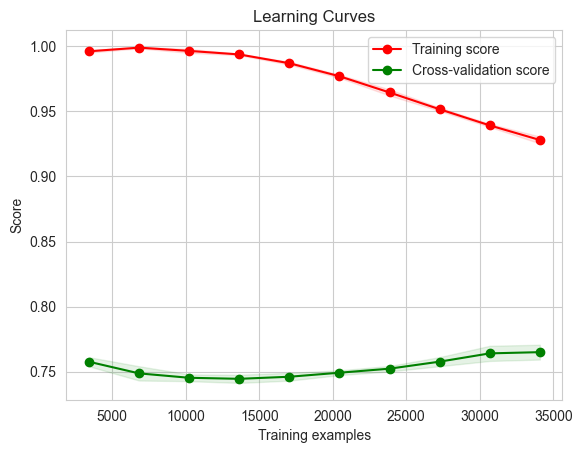

In [129]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X_train, y_train, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10),
        scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")

    plt.legend(loc="best")
    return plt


model = MLPClassifier(max_iter=500)
plot_learning_curves(model, x_train, y_train, cv=5)
plt.show()

# 5. Model Evaluation

In [75]:
# evaluate with test set
y_pred = logreg_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred_logreg = logreg_classifier.predict(x_test)

0.8855555555555555
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1566
           1       0.95      0.84      0.89      1836
           2       0.67      0.97      0.79       432
           3       0.87      0.90      0.88       756
           4       0.84      0.90      0.87       594
           5       0.79      1.00      0.88       216

    accuracy                           0.89      5400
   macro avg       0.85      0.92      0.87      5400
weighted avg       0.90      0.89      0.89      5400

[[1399   35   30   45   44   13]
 [  49 1536  157   43   32   19]
 [   1    4  419    3    2    3]
 [  11   22   15  677   26    5]
 [  14   11    9    8  536   16]
 [   0    1    0    0    0  215]]


In [76]:
y_pred = mnb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.8964814814814814
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1566
           1       0.97      0.85      0.91      1836
           2       0.67      0.95      0.79       432
           3       0.89      0.92      0.90       756
           4       0.85      0.92      0.88       594
           5       0.74      0.95      0.83       216

    accuracy                           0.90      5400
   macro avg       0.85      0.92      0.87      5400
weighted avg       0.91      0.90      0.90      5400

[[1416   23   27   45   38   17]
 [  20 1567  159   31   27   32]
 [   2   13  412    2    2    1]
 [   9    4   14  696   25    8]
 [  15    4    4   12  545   14]
 [   1    5    1    0    4  205]]


In [121]:
y_pred = svm_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
y_pred_svm = y_pred.copy()


0.8335804299481097
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1566
           1       0.91      0.83      0.87      1835
           2       0.62      0.82      0.71       431
           3       0.83      0.80      0.82       755
           4       0.77      0.83      0.80       593
           5       0.60      0.86      0.71       216

    accuracy                           0.83      5396
   macro avg       0.77      0.83      0.80      5396
weighted avg       0.85      0.83      0.84      5396

[[1332   53   29   65   57   30]
 [  53 1528  154   33   27   40]
 [  12   47  354    6    4    8]
 [  43   26   18  607   40   21]
 [  38   11   10   17  491   26]
 [   2    7    2    4   15  186]]


In [78]:
y_pred = xgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.9131481481481482
              precision    recall  f1-score   support

           0       0.98      0.90      0.93      1566
           1       0.97      0.89      0.93      1836
           2       0.74      0.98      0.84       432
           3       0.88      0.93      0.90       756
           4       0.87      0.93      0.90       594
           5       0.79      0.98      0.88       216

    accuracy                           0.91      5400
   macro avg       0.87      0.93      0.90      5400
weighted avg       0.92      0.91      0.91      5400

[[1402   44   15   55   37   13]
 [  21 1638  124   25   10   18]
 [   1    3  423    1    1    3]
 [   5    4    6  705   31    5]
 [   5    2    3   17  551   16]
 [   0    1    0    0    3  212]]


In [62]:
y_pred = lgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred_lgb = y_pred.copy()

0.9186434395848777
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1566
           1       0.96      0.90      0.93      1835
           2       0.76      0.97      0.85       431
           3       0.89      0.94      0.91       755
           4       0.88      0.94      0.91       593
           5       0.81      0.98      0.89       216

    accuracy                           0.92      5396
   macro avg       0.88      0.94      0.91      5396
weighted avg       0.93      0.92      0.92      5396

[[1419   46   10   49   33    9]
 [  27 1643  118   22    9   16]
 [   0    7  417    3    2    2]
 [   7    5    3  709   26    5]
 [   4    1    2   12  558   16]
 [   0    1    0    1    3  211]]


In [80]:
y_pred = adaboost_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.11074074074074074
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1566
           1       0.00      0.00      0.00      1836
           2       0.08      0.99      0.15       432
           3       0.00      0.00      0.00       756
           4       0.21      0.01      0.02       594
           5       0.74      0.77      0.75       216

    accuracy                           0.11      5400
   macro avg       0.17      0.29      0.15      5400
weighted avg       0.06      0.11      0.04      5400

[[   0    0 1553    0    1   12]
 [   0    0 1816    0    0   20]
 [   0    0  427    0    0    5]
 [   0    0  747    0    2    7]
 [   0    1  574    0    5   14]
 [  20    0    0   14   16  166]]


In [81]:
y_pred = knn_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.7433333333333333
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1566
           1       0.93      0.68      0.78      1836
           2       0.63      0.69      0.66       432
           3       0.48      0.89      0.62       756
           4       0.71      0.78      0.74       594
           5       0.70      0.81      0.75       216

    accuracy                           0.74      5400
   macro avg       0.73      0.76      0.73      5400
weighted avg       0.80      0.74      0.75      5400

[[1161   44   29  258   62   12]
 [  59 1246  123  294   80   34]
 [  14   26  297   76   15    4]
 [  19   16   16  674   21   10]
 [  21    6    5   85  462   15]
 [   6    5    3   21    7  174]]


In [82]:
y_pred = rf_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9175925925925926
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1566
           1       0.98      0.89      0.93      1836
           2       0.73      0.99      0.84       432
           3       0.89      0.95      0.92       756
           4       0.88      0.93      0.90       594
           5       0.81      0.99      0.89       216

    accuracy                           0.92      5400
   macro avg       0.88      0.94      0.90      5400
weighted avg       0.93      0.92      0.92      5400

[[1414   26   21   52   42   11]
 [  24 1635  131   20   11   15]
 [   0    2  427    0    0    3]
 [   4    7    5  715   21    4]
 [   6    4    3   13  551   17]
 [   0    1    1    0    1  213]]


In [83]:
y_pred = mlp_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9101851851851852
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1566
           1       0.97      0.87      0.92      1836
           2       0.74      0.94      0.83       432
           3       0.90      0.94      0.92       756
           4       0.85      0.90      0.87       594
           5       0.81      0.92      0.86       216

    accuracy                           0.91      5400
   macro avg       0.87      0.92      0.89      5400
weighted avg       0.92      0.91      0.91      5400

[[1460   18    5   36   44    3]
 [  38 1605  129   22   19   23]
 [   2   17  408    1    3    1]
 [  16    5    2  707   21    5]
 [  18    6    3   17  537   13]
 [   0    5    1    2   10  198]]


# 6. Cause of errors


In [122]:
emotions_to_int = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5
}

int_to_emotions = {v: k for k, v in emotions_to_int.items()}

prediction = y_pred_svm
wrong_predictions = y_test[y_test != prediction].index
for i, index in enumerate(wrong_predictions):
    if i == 10:
        break
    print(test_data['text'][index])
    print('Real: ', int_to_emotions[test_data['label'][index]])
    print('Pred:', int_to_emotions[prediction[index]])
    print('\n')



['feel', 'awful', 's', 'job', 'position', 'succeed', 'just', 'didn', 't', 'happen']
Real:  sadness
Pred: joy


['ive', 'probably', 'mentioned', 'but', 'really', 'feel', 'proud', 'actually', 'keeping', 'new', 'year', 'resolution', 'monthly', 'weekly', 'goal']
Real:  joy
Pred: sadness


['frustrated', 'christian', 'feel', 'constantly', 'talk', 'loving', 'praying', 'seen', 'not', 'case']
Real:  love
Pred: anger


['struggling', 'awful', 'feeling', 'saying', 'sweet', 'thing', 'not', 'deserving', 'sister', 'friendship', 'agreed', 'car', 'just', 'starting', 'drive', 'away', 'reached', 'hand']
Real:  joy
Pred: anger


['feel', 'enraged', 'but', 'helpless', 'time']
Real:  anger
Pred: fear


['wish', 'knew', 'word', 'write', 'write', 'think', 's', 'useless', 'm', 'just', 'heartless', 'feeling', 's', 'w']
Real:  sadness
Pred: anger


['feel', 'assured', 'no', 'thing', 'ultimate', 'forgetting', 'trace', 'impressed', 'memory', 'indestructible']
Real:  joy
Pred: surprise


['feel', 'blessed', 'ever

In [123]:
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

[[1332   53   29   65   57   30]
 [  53 1528  154   33   27   40]
 [  12   47  354    6    4    8]
 [  43   26   18  607   40   21]
 [  38   11   10   17  491   26]
 [   2    7    2    4   15  186]]
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1566
           1       0.91      0.83      0.87      1835
           2       0.62      0.82      0.71       431
           3       0.83      0.80      0.82       755
           4       0.77      0.83      0.80       593
           5       0.60      0.86      0.71       216

    accuracy                           0.83      5396
   macro avg       0.77      0.83      0.80      5396
weighted avg       0.85      0.83      0.84      5396


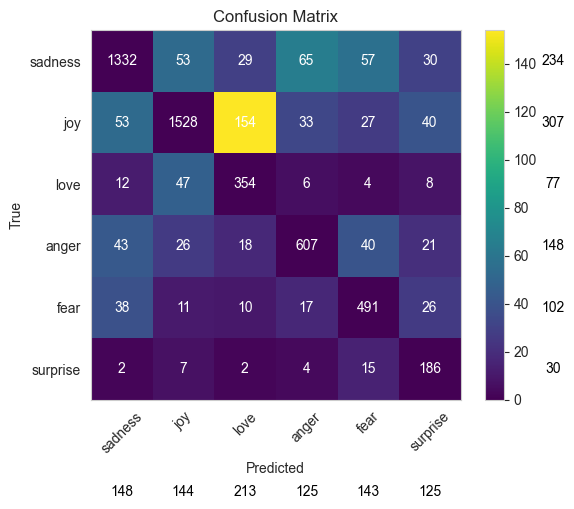

In [125]:
# check which emotions are being confused
plt.clf()
conf_matrix = confusion_matrix(y_test, prediction)
conf_matrix_copy = conf_matrix.copy()
for i in range(conf_matrix.shape[0]):
    conf_matrix[i, i] = 0 # make the diagonal null, to not eclipse the other values
    
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
# remove plot grid
plt.grid(False)
# annotate the axes with the emotion names
plt.xticks(range(6), int_to_emotions.values(), rotation=45)
plt.yticks(range(6), int_to_emotions.values())
# add colorbar more to the right
plt.colorbar()
# legend the axes with predicted and true values
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# add counts in the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == j:
            plt.text(j, i, conf_matrix_copy[i, j], ha='center', va='center', color='white')
        else:
            plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='white')

for i in range(conf_matrix.shape[0]): # this does not count correct predictions
    plt.text(7, i, conf_matrix[i, :].sum(), ha='center', va='center', color='black')
for i in range(conf_matrix.shape[1]):
    plt.text(i, 7, conf_matrix[:, i].sum(), ha='center', va='center', color='black')
plt.show()

The test set appears to be unbalance.
- 'joy' is a lot more mixed with 'love' than the contrary. 
- 'surprise' has a low Precision

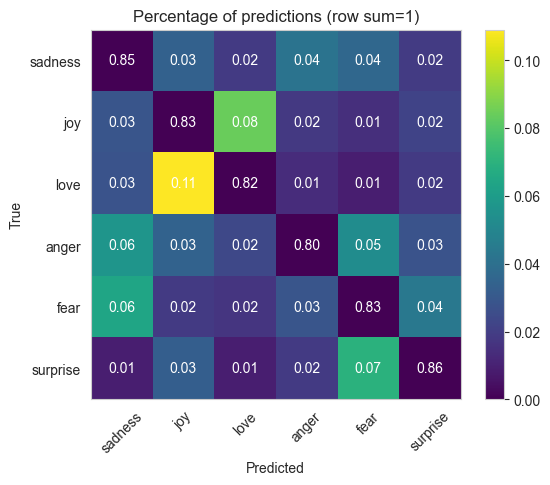

In [126]:
conf_matrix = confusion_matrix(y_test, prediction)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, None] # normalize the confusion matrix
conf_matrix_copy = conf_matrix.copy()
for i in range(conf_matrix.shape[0]):
    conf_matrix[i, i] = 0 # make the diagonal null, to not eclipse the other values
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.grid(False)

plt.xticks(range(6), int_to_emotions.values(), rotation=45)
plt.yticks(range(6), int_to_emotions.values())
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

# add counts in the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == j:
            plt.text(j, i, f'{conf_matrix_copy[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            plt.text(j, i, f'{conf_matrix[i, j]:.2f}', ha='center', va='center', color='white')

        
plt.title('Percentage of predictions (row sum=1)')
# Rows add to 1
plt.show()



- sadness mixed with joy and anger
- joy mixed with love
- love mixed with joy
- anger mixed with sadness and joy??
- fear mixed with sadness
- surprise mixed with almost everything

# 7. Experiment with user-inputed setences

In [84]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import text

emotions = {
    0: "0. sadness",
    1: "1. joy",
    2: "2. love",
    3: "3. anger",
    4: "4. fear",
    5: "5. surprise"
}

def preprocess_text(phrase):
    # Tokenize
    tokens = nltk.word_tokenize(phrase.lower())

    # Remove stop words
    my_stop_words = set(stopwords.words('english'))
    words_to_keep = frozenset(['no', 'couldnt', 'cry', 'not', 'cant', 'cannot', 'nor', 'except', 'nobody', 'off', 'but', 'serious', 'enough', 'nothing', 'alone', 'down', 'only', 'without','hereby'])
    my_stop_words -= words_to_keep
    tokens = [word for word in tokens if word not in my_stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

def doc2vec_text(tokens):
    model = Doc2Vec.load("d2v_best_stopwords.model")
    return model.infer_vector(tokens)

def classify_emotion(number):
    if number==0:
        return "0. sadness"
    if number==1:
        return "1. joy"
    if number==2:
        return "2. love"
    if number==3:
        return "3. anger"
    if number==4:
        return "4. fear"
    if number==5:
        return "5. surprise"

    return "Not possible to identify"


def analyze_sentiment(phrase):
    tokens = preprocess_text(phrase)
    tokens_embeddings = doc2vec_text(tokens)

    # Reshape to have proper structure
    tokens_embeddings = np.array(tokens_embeddings).reshape(1, -1)

    # Predict the class using the SVM classifier
    predicted_class = lgb_classifier.predict(tokens_embeddings)
    print(classify_emotion(predicted_class[0]))
    
def sentence_to_vector(sentence):
    tokens = preprocess_text(sentence)
    tokens_embeddings = doc2vec_text(tokens)
    return tokens_embeddings


In [85]:
phrase = "i love love"
analyze_sentiment(phrase)

ValueError: Number of features of the model must match the input. Model n_features_ is 40000 and input n_features is 88

## Misc

### Word Embeddings testing

In [139]:
model_glove_twitter = api.load("glove-twitter-100")
happy_vec = model_glove_twitter.get_vector('happy')

In [140]:
sad_vec = model_glove_twitter.get_vector('sad')

In [141]:
# compare
np.dot(happy_vec, sad_vec)


24.223938

In [142]:
list1 = ['happy', 'sad', 'angry', 'fear', 'surprise', 'love']

for word in list1:
    for word2 in list1:
        vec1 = model_glove_twitter.get_vector(word)
        vec2 = model_glove_twitter.get_vector(word2)
        print(f'{word} - {word2}: {np.dot(vec1, vec2)}')

happy - happy: 43.754364013671875
happy - sad: 24.22393798828125
happy - angry: 16.345155715942383
happy - fear: 12.840924263000488
happy - surprise: 20.760772705078125
happy - love: 34.92958450317383
sad - happy: 24.22393798828125
sad - sad: 38.538841247558594
sad - angry: 21.6543025970459
sad - fear: 20.165283203125
sad - surprise: 15.245964050292969
sad - love: 26.230363845825195
angry - happy: 16.345155715942383
angry - sad: 21.6543025970459
angry - angry: 28.474971771240234
angry - fear: 18.885839462280273
angry - surprise: 11.685001373291016
angry - love: 17.105241775512695
fear - happy: 12.840924263000488
fear - sad: 20.165283203125
fear - angry: 18.885839462280273
fear - fear: 37.312435150146484
fear - surprise: 10.949886322021484
fear - love: 20.85854148864746
surprise - happy: 20.760772705078125
surprise - sad: 15.245964050292969
surprise - angry: 11.685001373291016
surprise - fear: 10.949886322021484
surprise - surprise: 26.94860076904297
surprise - love: 18.885562896728516


In [143]:
list2 = ['happy', 'castle', 'unhappy', 'mom', 'game', 'water']

for word in list2:
    for word2 in list2:
        vec1 = model_glove_twitter.get_vector(word)
        vec2 = model_glove_twitter.get_vector(word2)
        print(f'{word} - {word2}: {np.dot(vec1, vec2)}')
        


happy - happy: 43.754364013671875
happy - castle: 12.034024238586426
happy - unhappy: 13.99042797088623
happy - mom: 26.998214721679688
happy - game: 18.880996704101562
happy - water: 12.893235206604004
castle - happy: 12.034024238586426
castle - castle: 33.73011016845703
castle - unhappy: 3.9025256633758545
castle - mom: 9.389619827270508
castle - game: 16.043418884277344
castle - water: 12.81629753112793
unhappy - happy: 13.99042797088623
unhappy - castle: 3.9025256633758545
unhappy - unhappy: 34.128849029541016
unhappy - mom: 12.150673866271973
unhappy - game: 5.554847240447998
unhappy - water: 7.630435943603516
mom - happy: 26.998214721679688
mom - castle: 9.389619827270508
mom - unhappy: 12.150673866271973
mom - mom: 37.74396514892578
mom - game: 17.937639236450195
mom - water: 17.61774253845215
game - happy: 18.880996704101562
game - castle: 16.043418884277344
game - unhappy: 5.554847240447998
game - mom: 17.937639236450195
game - game: 44.55514907836914
game - water: 15.57138824

In [144]:
list3 = ['man', 'woman', 'king', 'queen', 'germany', 'france', 'paris', 'berlin']

for word in list3:
    for word2 in list3:
        vec1 = model_glove_twitter.get_vector(word)
        vec2 = model_glove_twitter.get_vector(word2)
        print(f'{word} - {word2}: {np.dot(vec1, vec2)}')

man - man: 40.658973693847656
man - woman: 26.042871475219727
man - king: 18.844642639160156
man - queen: 13.50074291229248
man - germany: 15.163900375366211
man - france: 11.202445983886719
man - paris: 12.94122314453125
man - berlin: 11.269183158874512
woman - man: 26.042871475219727
woman - woman: 37.115867614746094
woman - king: 15.821100234985352
woman - queen: 18.255599975585938
woman - germany: 13.00075626373291
woman - france: 12.808996200561523
woman - paris: 12.195499420166016
woman - berlin: 7.850008487701416
king - man: 18.844642639160156
king - woman: 15.821100234985352
king - king: 28.84543800354004
king - queen: 20.43501853942871
king - germany: 10.667684555053711
king - france: 11.604635238647461
king - paris: 13.265036582946777
king - berlin: 8.66583251953125
queen - man: 13.50074291229248
queen - woman: 18.255599975585938
queen - king: 20.43501853942871
queen - queen: 28.91381072998047
queen - germany: 12.133584976196289
queen - france: 12.15859317779541
queen - paris

In [146]:
model_glove_twitter.similarity('happy', 'sad')


0.5899086